In [393]:
import mne
import pickle
from brainflow import BoardShim
from brainflow import BoardShim
from speller_config import *
from mne import create_info
import matplotlib.pyplot as plt
import numpy as np
from mne import time_frequency

### Stacking same class epochs and plotting stft

In [394]:
# from glob import glob
# import os
# import numpy as np
# import mne

# def read_data(fpath):
#     raw = mne.io.read_raw_fif(fpath, preload=True)
#     x = raw.get_data()[:8, 250:1250]
#     return np.expand_dims(x, axis=0)

# files = glob(r'E:\Thesis\HybridSpeller\nine_flicker\record\farheen_20230427_v2\*.fif')

# data = {'A': [], 'B': [], 'C': [], 'D': [], 'E': [], 'F': [], 'G': [], 'H': [], 'I': []}

# for fpath in files:
#     filename = os.path.basename(fpath)
#     group = filename[1]
#     x = read_data(fpath)
#     if group in data:
#         data[group].append(x)

# X_A = np.concatenate(data['A'])
# X_B = np.concatenate(data['B'])
# X_C = np.concatenate(data['C'])
# X_D = np.concatenate(data['D'])
# X_E = np.concatenate(data['E'])
# X_F = np.concatenate(data['F'])
# X_G = np.concatenate(data['G'])
# X_H = np.concatenate(data['H'])
# X_I = np.concatenate(data['I'])


# print(X_A.shape, X_B.shape, X_C.shape)


In [395]:
# stft_data = []
# for i in range(X_G.shape[0]):
#     stft = time_frequency.stft(X_G[i], wsize=252, verbose=False); 
#     stft_data.append(np.expand_dims(stft, axis=0))
# stft_data = np.concatenate(stft_data, axis=0)
# stft_data.shape

In [396]:
# ch_names = ['Fz', 'C3', 'Cz', 'C4', 'Pz', 'PO7', 'Oz', 'PO8', 'STIM MARKERS']

# for ch_idx in range(0,8):
#     X = stft_data
#     X = X[:20]
#     print(X.shape)
#     # X = abs(X)
#     X = X.mean(axis=0)
#     X = X[ch_idx]
#     X = X[:45,:]
#     print(X.shape)

#     c = plt.pcolormesh(np.arange(0,(X.shape[1]) //2,0.5), range(X.shape[0]), np.abs(X), cmap='plasma', vmax=10e-6)
#     plt.colorbar(c)
#     plt.title(f'STFT Magnitude {ch_names[ch_idx]} {ch_idx=}')
#     plt.ylabel('Frequency [Hz]')
#     plt.xlabel('Time [sec]')
#     plt.show()

### Plotting stft for each epoch

In [397]:
# fname = r'E:\Thesis\HybridSpeller\nine_flicker\record\vineet_20230423\0A.fif'

# raw =  mne.io.read_raw_fif(fname,  preload = True)
# raw.plot()
# data = raw.get_data()[:8,250:1250]
# new_raw = mne.io.RawArray(data,raw.info)
# new_raw.plot()

In [398]:
# stft_data = []
# data = np.expand_dims(data,axis=0)
# print(data.shape)
# for i in range(data.shape[0]):
#     stft = time_frequency.stft(data[i], wsize=252, verbose=False); 
#     stft_data.append(np.expand_dims(stft, axis=0))
# stft_data = np.concatenate(stft_data, axis=0)
# stft_data.shape

In [399]:
# for ch_idx in range(1,8):
#     stft = stft_data[0,ch_idx]
#     stft = stft[:30,:]
#     c = plt.pcolormesh(np.arange(0,(stft.shape[1]) //2,0.5), range(stft.shape[0]), np.abs(stft), cmap='plasma', vmax=10e-6)
#     plt.colorbar(c)
#     plt.title(f'STFT Magnitude {raw.ch_names[ch_idx]} {ch_idx=}')
#     plt.ylabel('Frequency [Hz]')
#     plt.xlabel('Time [sec]')
#     plt.show()

In [400]:
from numpy import ndarray
import numpy as np
from scipy.sparse import vstack, identity, spmatrix
from typing import Optional, cast, Union
from scipy.linalg import eigh
from scipy.sparse.linalg import eigsh
from scipy.stats import pearsonr
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin
from joblib import Parallel, delayed
from functools import partial



def _ged_wong(
    Z: ndarray,
    D: Optional[ndarray] = None,
    P: Optional[ndarray] = None,
    n_components=1,
    method="type1",
):
    if method != "type1" and method != "type2":
        raise ValueError("not supported method type")

    A = Z
    if D is not None:
        A = D.T @ A
    if P is not None:
        A = P.T @ A
    A = A.T @ A
    if method == "type1":
        B = Z
        if D is not None:
            B = D.T @ Z
        B = B.T @ B
        if isinstance(A, spmatrix) or isinstance(B, spmatrix):
            D, W = eigsh(A, k=n_components, M=B)
        else:
            D, W = eigh(A, B)
    elif method == "type2":
        if isinstance(A, spmatrix):
            D, W = eigsh(A, k=n_components)
        else:
            D, W = eigh(A)

    D_exist = cast(ndarray, D)
    ind = np.argsort(D_exist)[::-1]
    D_exist, W = D_exist[ind], W[:, ind]
    return D_exist[:n_components], W[:, :n_components]


def _trca_kernel(X: ndarray):
    """TRCA.
    X: (n_trials, n_channels, n_samples)
    """
    X = np.reshape(X, (-1, *X.shape[-2:]))
    M, C, N = X.shape
    n_components = C
    P = vstack([identity(N) for _ in range(M)])
    P = P @ P.T
    # P = abs(P @ P.T)
    Z = np.hstack(X).T  # type: ignore
    _, U = _ged_wong(Z, None, P, n_components=n_components)  # U for X
    return U


def _trca_feature(
    X: ndarray,
    templates: ndarray,
    Us: ndarray,
    n_components: int = 1,
    ensemble: bool = True,
):
    rhos = []
    if not ensemble:
        for Xk, U in zip(templates, Us):
            a = U[:, :n_components].T @ X
            b = U[:, :n_components].T @ Xk
            a = np.reshape(a, (-1))
            b = np.reshape(b, (-1))
            rhos.append(pearsonr(a, b)[0])
    else:
        U = Us[:, :, :n_components]
        U = np.concatenate(U, axis=-1)
        for Xk in templates:
            a = U.T @ X
            b = U.T @ Xk
            a = np.reshape(a, (-1))
            b = np.reshape(b, (-1))
            rhos.append(pearsonr(a, b)[0])
    return rhos


class TRCA(BaseEstimator, TransformerMixin, ClassifierMixin):
    def __init__(
        self, n_components: int = 1, ensemble: bool = True, n_jobs: Optional[int] = None
    ):
        self.n_components = n_components
        self.ensemble = ensemble
        self.n_jobs = n_jobs

    def fit(self, X: ndarray, y: ndarray, Yf: Optional[ndarray] = None):
        self.classes_ = np.unique(y)
        X = np.reshape(X, (-1, *X.shape[-2:]))
        X = X - np.mean(X, axis=-1, keepdims=True)
        self.templates_ = np.stack(
            [np.mean(X[y == label], axis=0) for label in self.classes_]
        )

        self.Us_ = np.stack([_trca_kernel(X[y == label]) for label in self.classes_])
        return self

    def transform(self, X: ndarray):
        X = np.reshape(X, (-1, *X.shape[-2:]))
        X = X - np.mean(X, axis=-1, keepdims=True)
        n_components = self.n_components
        templates = self.templates_
        Us = self.Us_
        ensemble = self.ensemble
        rhos = Parallel(n_jobs=self.n_jobs)(
            delayed(
                partial(
                    _trca_feature, Us=Us, n_components=n_components, ensemble=ensemble
                )
            )(a, templates)
            for a in X
        )
        rhos = np.stack(rhos)
        return rhos

    def predict(self, X: ndarray):
        feat = self.transform(X)
        labels = self.classes_[np.argmax(feat, axis=-1)]
        return labels


def generate_cca_references(
    freqs,
    srate,
    T,
    phases: Optional[Union[ndarray, int, float]] = None,
    n_harmonics: int = 1,
):
    if isinstance(freqs, int) or isinstance(freqs, float):
        freqs = [freqs]
    freqs = np.array(freqs)[:, np.newaxis]
    if phases is None:
        phases = 0
    if isinstance(phases, int) or isinstance(phases, float):
        phases = np.array([phases])
    phases = np.array(phases)[:, np.newaxis]
    t = np.linspace(0, T, int(T * srate))

    Yf = []
    for i in range(n_harmonics):
        Yf.append(
            np.stack(
                [
                    np.sin(2 * np.pi * (i + 1) * freqs * t + np.pi * phases),
                    np.cos(2 * np.pi * (i + 1) * freqs * t + np.pi * phases),
                ],
                axis=1,
            )
        )
    Yf = np.concatenate(Yf, axis=1)
    return Yf

### Passing all epoch in loop to TRCA

In [401]:
from glob import glob
import os
# files = glob(r'E:\Thesis\HybridSpeller\nine_flicker\record\farheen_20230427_v2\*.fif')
files = glob(r'E:\Thesis\HybridSpeller\nine_flicker\record\sunsun_20230424_v2\*.fif')

picked_channels = ['PO7', 'Oz', 'PO8']

y = []
X = []
for fpath in files:
    _,filename = os.path.split(fpath)
    y.append(filename[1])

    raw =  mne.io.read_raw_fif(fpath,  preload = True)
    # raw.pick_channels(picked_channels)
    x = raw.get_data()[:8,475:1475]
    X.append(np.expand_dims(x,axis=0))

y = np.array(y)
X = np.concatenate(X)

print(X.shape, y.shape)

# fname = r'E:\Thesis\HybridSpeller\three_flicker\record\sunsun_20230420\2C.fif'

# raw =  mne.io.read_raw_fif(fname,  preload = True)
# raw.plot()
# data = raw.get_data()[:8,250:1250]
# new_raw = mne.io.RawArray(data,raw.info)
# new_raw.plot()

Opening raw data file E:\Thesis\HybridSpeller\nine_flicker\record\sunsun_20230424_v2\0A.fif...
    Range : 0 ... 1754 =      0.000 ...     7.016 secs
Ready.
Reading 0 ... 1754  =      0.000 ...     7.016 secs...
Opening raw data file E:\Thesis\HybridSpeller\nine_flicker\record\sunsun_20230424_v2\0B.fif...
    Range : 0 ... 1752 =      0.000 ...     7.008 secs
Ready.
Reading 0 ... 1752  =      0.000 ...     7.008 secs...
Opening raw data file E:\Thesis\HybridSpeller\nine_flicker\record\sunsun_20230424_v2\0C.fif...
    Range : 0 ... 1754 =      0.000 ...     7.016 secs
Ready.
Reading 0 ... 1754  =      0.000 ...     7.016 secs...
Opening raw data file E:\Thesis\HybridSpeller\nine_flicker\record\sunsun_20230424_v2\0D.fif...
    Range : 0 ... 1753 =      0.000 ...     7.012 secs
Ready.
Reading 0 ... 1753  =      0.000 ...     7.012 secs...
Opening raw data file E:\Thesis\HybridSpeller\nine_flicker\record\sunsun_20230424_v2\0E.fif...
    Range : 0 ... 1751 =      0.000 ...     7.004 secs
Re

C:\Users\Sunsun\AppData\Local\Temp\ipykernel_1384\1602876165.py:14: RuntimeWarning: This filename (E:\Thesis\HybridSpeller\nine_flicker\record\sunsun_20230424_v2\0A.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw =  mne.io.read_raw_fif(fpath,  preload = True)
C:\Users\Sunsun\AppData\Local\Temp\ipykernel_1384\1602876165.py:14: RuntimeWarning: This filename (E:\Thesis\HybridSpeller\nine_flicker\record\sunsun_20230424_v2\0B.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw =  mne.io.read_raw_fif(fpath,  preload = True)
C:\Users\Sunsun\AppData\Local\Temp\ipykernel_1384\1602876165.py:14: RuntimeWarning: This filename (E

Reading 0 ... 1752  =      0.000 ...     7.008 secs...
Opening raw data file E:\Thesis\HybridSpeller\nine_flicker\record\sunsun_20230424_v2\2H.fif...
    Range : 0 ... 1755 =      0.000 ...     7.020 secs
Ready.
Reading 0 ... 1755  =      0.000 ...     7.020 secs...
Opening raw data file E:\Thesis\HybridSpeller\nine_flicker\record\sunsun_20230424_v2\2I.fif...
    Range : 0 ... 1749 =      0.000 ...     6.996 secs
Ready.
Reading 0 ... 1749  =      0.000 ...     6.996 secs...
Opening raw data file E:\Thesis\HybridSpeller\nine_flicker\record\sunsun_20230424_v2\sunsun_20230424_v2.fif...
    Range : 0 ... 47009 =      0.000 ...   188.036 secs
Ready.
Reading 0 ... 47009  =      0.000 ...   188.036 secs...
(28, 8, 1000) (28,)


C:\Users\Sunsun\AppData\Local\Temp\ipykernel_1384\1602876165.py:14: RuntimeWarning: This filename (E:\Thesis\HybridSpeller\nine_flicker\record\sunsun_20230424_v2\2H.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw =  mne.io.read_raw_fif(fpath,  preload = True)
C:\Users\Sunsun\AppData\Local\Temp\ipykernel_1384\1602876165.py:14: RuntimeWarning: This filename (E:\Thesis\HybridSpeller\nine_flicker\record\sunsun_20230424_v2\2I.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw =  mne.io.read_raw_fif(fpath,  preload = True)
C:\Users\Sunsun\AppData\Local\Temp\ipykernel_1384\1602876165.py:14: RuntimeWarning: This filename (E

In [402]:
print(X.shape, y.shape)
loaded_model = pickle.load(open(r"E:\Thesis\HybridSpeller\nine_flicker\TRCA_model.sav", 'rb'))

(28, 8, 1000) (28,)


In [403]:
loaded_model.n_components

9

In [404]:
preds = loaded_model.predict(X)

In [405]:
print(preds)
print(y)


[5 8 3 4 5 5 1 6 9 1 2 4 6 9 4 7 6 3 8 2 3 4 5 6 7 8 7 1]
['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I'
 'A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'u']


In [406]:
c = 0
for idx in range(len(preds)):
    pred = preds[idx]
    label = y[idx]
    if(pred == 1):
        pred = 'A'
    if(pred == 2):
        pred = 'B'
    if(pred == 3):
        pred = 'C'
    if(pred == 4):
        pred = 'D'
    if(pred == 5):
        pred = 'E'
    if(pred == 6):
        pred = 'F'
    if(pred == 7):
        pred = 'G'
    if(pred == 8):
        pred = 'H'
    if(pred == 9):
        pred = 'I'
        
    if(label == pred):
        c += 1

acc = c/len(preds)
print(acc)

0.5


### Passing each pickle file into TRCA

In [407]:
from glob import glob
import os
from scipy import signal

loaded_model = pickle.load(open(r"E:\Thesis\HybridSpeller\nine_flicker\TRCA_model.sav", 'rb'))
# pickle_files = glob(r'E:\Thesis\HybridSpeller\nine_flicker\record\farheen_20230427_v2\*.pickle')
pickle_files = glob(r'E:\Thesis\HybridSpeller\nine_flicker\record\sunsun_20230424_v2\*.pickle')

y_pickle = []
X_pickle = []
for fpath in pickle_files:
    _,filename = os.path.split(fpath)
    y_pickle.append(filename[1])

    with open(fpath, 'rb') as handle:
        pickle_data = pickle.load(handle)

    marker_channel = BoardShim.get_marker_channel(BOARD_ID)
    eeg_channels = BoardShim.get_eeg_channels(BOARD_ID)
    pickle_data[eeg_channels] = pickle_data[eeg_channels] / 1e6
    pickle_data = pickle_data[eeg_channels + [marker_channel]]

    _CHANNELS = ['FZ', 'C3', 'CZ', 'C4', 'PZ', 'PO7', 'OZ', 'PO8']

    # data = pickle_data[:8,:1740]  # pickle-sunsun_20230420_night
    # data = pickle_data[5:8,:1740]
    data = pickle_data[:8,:1740]
    print(data.shape)
    
    # order = 1
    # l_freq = 4
    # sos = signal.butter(order, l_freq, 'highpass', analog=False, fs=250, output='sos')

    b,a = signal.iirfilter(10, Wn=[7, 90],  btype='band', analog=False, fs=250,  ftype='butter')
    data = signal.filtfilt(b,a,data,axis=1)

    # notch_freq = 50
    # quality = 1
    # b,a = signal.iirnotch(notch_freq, quality, fs=250)
    # for i in range(3):
        # data[i] = signal.lfilter(b, a, data[i])
        # data[i] = signal.sosfilt(sos, data[i])
    X_pickle.append(np.expand_dims(data[:],axis=0))
    # ch_names = [ch_name.upper() for ch_name in _CHANNELS]
    # ch_names = ch_names + ['STIM']
    # ch_types = ["eeg"] * 9
    # ch_types[-1] = "stim"

    # info = create_info(ch_names=ch_names, ch_types=ch_types, sfreq=250)
    # raw_pickle = mne.io.RawArray(pickle_data, info=info)
    # raw_pickle.notch_filter([50])
    # raw_pickle.filter(4,77)
    # x = raw_pickle.get_data()[:8,250:1250]
    # X_pickle.append(np.expand_dims(x,axis=0))

y_pickle = np.array(y_pickle)
X_pickle = np.concatenate(X_pickle)

print(X_pickle.shape, y_pickle.shape)

(8, 1740)
(8, 1740)
(8, 1740)
(8, 1740)
(8, 1740)
(8, 1740)
(8, 1740)
(8, 1740)
(8, 1740)
(8, 1740)
(8, 1740)
(8, 1740)
(8, 1740)
(8, 1740)
(8, 1740)
(8, 1740)
(8, 1740)
(8, 1740)
(8, 1740)
(8, 1740)
(8, 1740)
(8, 1740)
(8, 1740)
(8, 1740)
(8, 1740)
(8, 1740)
(8, 1740)
(27, 8, 1740) (27,)


In [408]:
X_A = X_pickle[y_pickle=='A']
X_B = X_pickle[y_pickle=='B']
X_C = X_pickle[y_pickle=='C']
X_A.shape, X_B.shape, X_C.shape

((3, 8, 1740), (3, 8, 1740), (3, 8, 1740))

In [409]:
# stft_data = []
# for i in range(X_A.shape[0]):
#     stft = time_frequency.stft(X_A[i], wsize=252, verbose=False); 
#     stft_data.append(np.expand_dims(stft, axis=0))
# stft_data = np.concatenate(stft_data, axis=0)
# stft_data.shape

In [410]:
# plt.plot(X_A[0,0,])
# plt.show()

In [411]:
# for ch_idx in range(1,8):
#     X = stft_data
#     # X = abs(X)
#     X = X.mean(axis=0)
#     print(X.shape)
#     X = X[ch_idx]
#     X = X[:45,:]
#     # X[0,:] = 0
#     # X[1,:] = 0
#     # X[2,:] = 0
#     # X[3,:] = 0
#     # X[4,:] = 0
#     # X[5,:] = 0
#     # X[:,0] = 0
#     # X[:,-1] = 0
#     print(X.shape)

#     c = plt.pcolormesh(np.arange(0,(X.shape[1]) //2,0.5), range(X.shape[0]), np.abs(X), cmap='plasma', vmax=4e-6)
#     plt.colorbar(c)
#     plt.title(f'STFT Magnitude {raw.ch_names[ch_idx]} {ch_idx=} From Online Pickle')
#     plt.ylabel('Frequency [Hz]')
#     plt.xlabel('Time [sec]')
#     plt.show()

In [412]:
best_predict = None
best_score = 0
for r in range(500+1):
    offset = int(250 + r)
    preds_pickle = loaded_model.predict(X_pickle[:,:,offset:offset + 1000])
    # print(preds_pickle)
    # print(y_pickle)
    # print(X_pickle[:,:,offset:offset + 750].shape)
    c = 0
    preds_pickle_converted = []
    for idx in range(len(preds_pickle)):
        pred = preds_pickle[idx]
        label = y_pickle[idx]
        if(pred == 1):
            pred = 'A'
        if(pred == 2):
            pred = 'B'
        if(pred == 3):
            pred = 'C'
        if(pred == 4):
            pred = 'D'
        if(pred == 5):
            pred = 'E'
        if(pred == 6):
            pred = 'F'
        if(pred == 7):
            pred = 'G'
        if(pred == 8):
            pred = 'H'
        if(pred == 9):
            pred = 'I'
        preds_pickle_converted.append(pred)
        if(label == pred):
            c += 1
        # print(idx, f"{pred=} {label=}" )
    score = c/len(preds_pickle)
    print(offset, score)
    if(best_score < score):
        best_score = score
        best_predict = preds_pickle_converted

250 0.1111111111111111
251 0.14814814814814814
252 0.1111111111111111
253 0.14814814814814814
254 0.2222222222222222
255 0.14814814814814814
256 0.1111111111111111
257 0.1111111111111111
258 0.07407407407407407
259 0.14814814814814814
260 0.1111111111111111
261 0.14814814814814814
262 0.1111111111111111
263 0.14814814814814814
264 0.1111111111111111
265 0.07407407407407407
266 0.1111111111111111
267 0.14814814814814814
268 0.18518518518518517
269 0.2222222222222222
270 0.1111111111111111
271 0.14814814814814814
272 0.07407407407407407
273 0.14814814814814814
274 0.2222222222222222
275 0.07407407407407407
276 0.14814814814814814
277 0.1111111111111111
278 0.14814814814814814
279 0.14814814814814814
280 0.037037037037037035
281 0.07407407407407407
282 0.037037037037037035
283 0.14814814814814814
284 0.1111111111111111
285 0.037037037037037035
286 0.1111111111111111
287 0.1111111111111111
288 0.07407407407407407
289 0.18518518518518517
290 0.14814814814814814
291 0.18518518518518517
292 0

ValueError: x and y must have the same length.

In [413]:
offset = 473 ## we chose the best offset to fix time align issue
preds_pickle = loaded_model.predict(X_pickle[:,:,offset:offset + 1000])
# print(preds_pickle)
# print(y_pickle)
# print(X_pickle[:,:,offset:offset + 750].shape)
c = 0
preds_pickle_converted = []
for idx in range(len(preds_pickle)):
    pred = preds_pickle[idx]
    label = y_pickle[idx]
    if(pred == 1):
        pred = 'A'
    if(pred == 2):
        pred = 'B'
    if(pred == 3):
        pred = 'C'
    if(pred == 4):
        pred = 'D'
    if(pred == 5):
        pred = 'E'
    if(pred == 6):
        pred = 'F'
    if(pred == 7):
        pred = 'G'
    if(pred == 8):
        pred = 'H'
    if(pred == 9):
        pred = 'I'
    preds_pickle_converted.append(pred)
    if(label == pred):
        c += 1
    # print(idx, f"{pred=} {label=}" )
score = c/len(preds_pickle)
print(score)

0.25925925925925924


In [414]:
best_predict = preds_pickle_converted
print(y_pickle)
print(preds_pickle)
print(best_predict)

['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I'
 'A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I']
[5 3 5 5 3 5 2 2 1 1 7 6 5 5 6 7 6 3 4 7 5 4 7 6 7 7 5]
['E', 'C', 'E', 'E', 'C', 'E', 'B', 'B', 'A', 'A', 'G', 'F', 'E', 'E', 'F', 'G', 'F', 'C', 'D', 'G', 'E', 'D', 'G', 'F', 'G', 'G', 'E']


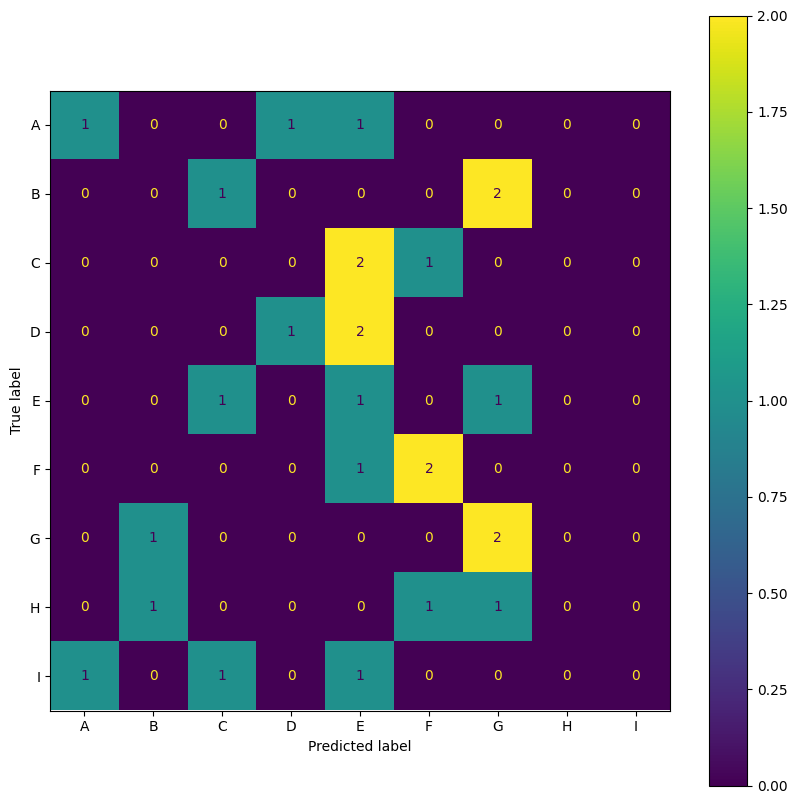

In [415]:
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay.from_predictions(y_pickle, best_predict)
fig = disp.figure_
fig.set_figwidth(10)
fig.set_figheight(10)
plt.show()

### Passing one pickle file into TRCA

In [ ]:
# pickle_filename = r'C:\Users\bci\Documents\projects\hybrid-ssvep-p300-speller\three_flicker\record\sunsun_20230423\0B.pickle'

# with open(pickle_filename, 'rb') as handle:
#     pickle_data = pickle.load(handle)

In [ ]:
# marker_channel = BoardShim.get_marker_channel(BOARD_ID)
# eeg_channels = BoardShim.get_eeg_channels(BOARD_ID)
# pickle_data[eeg_channels] = pickle_data[eeg_channels] / 1e6
# pickle_data = pickle_data[eeg_channels + [marker_channel]]

# # for i in range(9):
# #     plt.plot(pickle_data[i,-500:])
# #     plt.show()

In [ ]:
# _CHANNELS = ['FZ', 'C3', 'CZ', 'C4', 'PZ', 'PO7', 'OZ', 'PO8']
# ch_names = [ch_name.upper() for ch_name in _CHANNELS]
# ch_names = ch_names + ['STIM']
# ch_types = ["eeg"] * 9
# ch_types[-1] = "stim"

# info = create_info(ch_names=ch_names, ch_types=ch_types, sfreq=250)

In [ ]:
# raw_pickle = mne.io.RawArray(pickle_data, info=info)
# raw_pickle.notch_filter([50])
# raw_pickle.filter(4,77)
# raw_pickle.plot()

In [ ]:
# data = raw_pickle.get_data()[:8,250:1250]

In [ ]:
# pred = loaded_model.predict(data)
# print(pred)